# Balancing Act: Unveiling the Impact of Sampling Techniques on Imbalanced Dataset Classification Accuracy

Classification is a supervised machine learning method where the model tries to predict the correct label of a given input data. In classification, the model is fully trained using the training data, and then it is evaluated on test data before being used to perform prediction on new unseen data - [DataCamp](www.datacamp.com/blog/classification-machine-learning).

Imbalanced classification are those classification tasks where the distribution of samples across the classes is not equal. Practical imbalanced classification requires the use of a suite of specialized techniques, data preparation techniques, learning algorithms, and performance metrics.   [MachineLearningMastery](https://machinelearningmastery.com/).

### Import Libraries

In [1]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

## Prepare Data

### Explore Dataset

In [2]:
# with gzip.open('data/transactions.gz', 'rb') as f:
#     df = pd.read_csv(f)
df = pd.read_csv('data/transactions.gz', compression='gzip')
df.head()

,Unnamed: 0,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


In [3]:
df_fraud = df.drop(columns=df.columns[0], axis=1)

In [4]:
df_fraud.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,9.0,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,2.0,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


In [5]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  float64
 10  posConditionCode          785954 non-null  float64
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

<Axes: xlabel='isFraud', ylabel='count'>

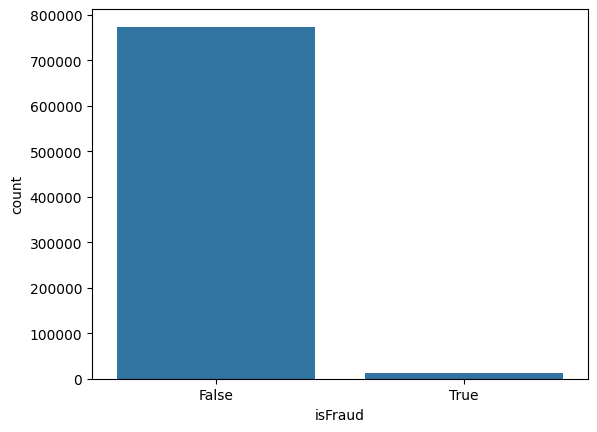

In [6]:
sns.countplot(df_fraud, x='isFraud')

In [7]:
df_fraud.isFraud.value_counts(normalize=True)

isFraud
False    0.98421
True     0.01579
Name: proportion, dtype: float64

The isFraud column has less than 2% fraud cases which is highly imbalance

### Check for Missing Values

In [8]:
# Let's check for percentage of missing values in each column
df_fraud.isnull().mean() 

accountNumber               0.000000
customerId                  0.000000
creditLimit                 0.000000
availableMoney              0.000000
transactionDateTime         0.000000
transactionAmount           0.000000
merchantName                0.000000
acqCountry                  0.005801
merchantCountryCode         0.000921
posEntryMode                0.005155
posConditionCode            0.000520
merchantCategoryCode        0.000000
currentExpDate              0.000000
accountOpenDate             0.000000
dateOfLastAddressChange     0.000000
cardCVV                     0.000000
enteredCVV                  0.000000
cardLast4Digits             0.000000
transactionType             0.000888
echoBuffer                  1.000000
currentBalance              0.000000
merchantCity                1.000000
merchantState               1.000000
merchantZip                 1.000000
cardPresent                 0.000000
posOnPremises               1.000000
recurringAuthInd            1.000000
e

### Load Data and Preprocess for Modelling
We have explored the dataset and can now create a function to wrangle the data for modeling

### Create a wrangle function to:
 - load data
 - drop unnamed column
 - drop columns with more than 20% missingness
 - Convert boolean values to string for categorical data encoding
 - Encode target variable (0 for the majority class and 1 for the minority class as is the custom for imbalance binary classification dataset)

In [9]:
# Cretae a wrangle function
def wrangle(filepath):
    # load file
    df = pd.read_csv(filepath, compression='gzip')

    # drop unnamed column
    df = df.drop(columns=df.columns[0], axis=1)

    #drop columns with more than 20% missingness
    dropped_cols = [col for col in df.columns if df[col].isnull().mean() > 0.2]
    df = df.drop(columns=dropped_cols)

    # Convert dateTime to numerical string 
    # df['transactionDateTime'] = (pd.to_datetime(df['transactionDateTime'])).dt.strftime('%Y%m%d%H%M%S')

    # Convert boolean values to string for categorical data encoding
    df["cardPresent"] = df["cardPresent"].replace({True: 'True', False: 'False'})
    df["expirationDateKeyInMatch"] = df["expirationDateKeyInMatch"].replace({True: 'True', False: 'False'})

    # Binary Encode target variables
    df["isFraud"] = df["isFraud"].map({False : 0, True : 1})

    return df

In [10]:
fraud_data = wrangle('data/transactions.gz')
fraud_data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,...,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,0
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,0
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,0
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,9.0,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,0
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,2.0,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,0


In [11]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  float64
 10  posConditionCode          785954 non-null  float64
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

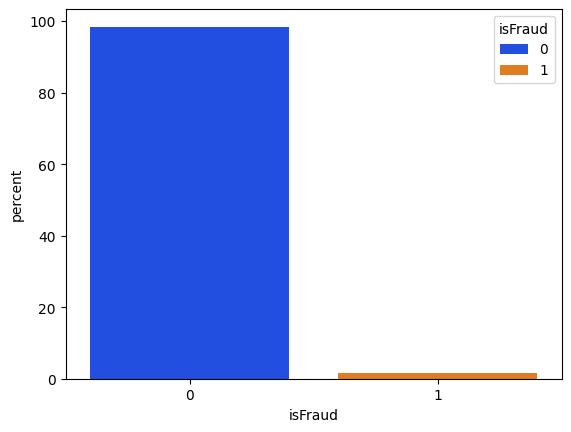

In [12]:
sns.countplot(fraud_data, x='isFraud', stat='percent',hue="isFraud", palette="bright");

In [13]:
fraud_data.isFraud.value_counts()

isFraud
0    773946
1     12417
Name: count, dtype: int64

## Build Model

### Split into Training and Test sets

In [14]:
# feature columns
X = fraud_data.drop(columns=["isFraud"])

# target column
y = fraud_data["isFraud"]
print(X.shape, y.shape)

(786363, 22) (786363,)


In [15]:
# Split the data into a training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(629090, 22) (157273, 22) (629090,) (157273,)


In [16]:
# Determine the majority class 
majority_class = Counter(y_train).most_common(1)[0][0]
# Predict the majority class for all instances in the test set
y_test_pred_majority = [majority_class] * len(y_test)
# Calculate accuracy
accuracy_score_majority = accuracy_score(y_test, y_test_pred_majority)
print(f"Base Model (Majority Voting) Accuracy on Test Set: {accuracy_score_majority}")

Base Model (Majority Voting) Accuracy on Test Set: 0.9841485824013022


### Data Preprocessing
- we will scale the numeric features using StandardScalar
- We will encode the categorical features using OneHotEncoder
- Impute missing values with Simpleimputer
- Then create separate pipelines for processing the categorical and numeric features

In [17]:
# Select Categorical columns in training set
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Select Numerical columns in training set
numeric_features = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

# Create transformers for numeric and categorical features
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

# Combine transformers for both types of features using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline
pipeline = make_pipeline(preprocessor)

### Train and Evaluate Model

we will create a model, then train and evaluate it on:
- 1. The training data without resampling
- 2. The training data with the majority class undersampled
- 3. The training data with the minority class oversampled

In [18]:
# Create a logistic regression model
model = make_pipeline(preprocessor, LogisticRegression(max_iter=10000))
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['accountNumber',
                                                   'customerId', 'creditLimit',
                                                   'availableMoney',
                                                   'transactionAmount',
                                                   'posEntryMode',
                                                   'posConditionCode',
                                                   'cardCVV', 'enteredCVV',
                                                   'cardLast4Digits',
                                                   'currentBalan...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['transactionDateTime',
                                                   'merchantName', 'acqCountry',
                                                   'merchantCountryCode',
                                                   'merchantCategoryCode',
                                                   'currentExpDate',
                                                   'accountOpenDate',
                                                   'dateOfLastAddressChange',
                                                   'transactionType',
                                                   'cardPresent',
                                                   'expirationDateKeyInMatch'])])),
                ('logisticregression', LogisticRegression(max_iter=10000))])

#### (1) Using Training Data without resampling

In [19]:
# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy_before_sampling = accuracy_score(y_test, y_pred)

In [44]:
print(sorted(Counter(y_train).items()))

[(0, 619166), (1, 9924)]


#### (2) Under-sample Training Data

In [20]:
# Under-sample the training data
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

# fit the model to the under-sampled training data
model.fit(X_train_under, y_train_under)

# Make predictions on the test data
y_pred_under = model.predict(X_test)

# Calculate accuracy
accuracy_after_under_sampling = accuracy_score(y_test, y_pred_under)

In [21]:
print(sorted(Counter(y_train_under).items()))

[(0, 9924), (1, 9924)]


#### (3) Over-sample Training Data

In [22]:
# Under-sample the training data
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)

# fit the model to the over-sampled training data
model.fit(X_train_over, y_train_over)

# Make predictions on the test data
y_pred_over = model.predict(X_test)

# Calculate accuracy
accuracy_after_over_sampling = accuracy_score(y_test, y_pred_over)

In [23]:
print(sorted(Counter(y_train_over).items()))

[(0, 619166), (1, 619166)]


#### Compare Performance

In [24]:
# Compare model accuracy
print(f"Logistic Regression Model Accuracy (Before Sampling): {accuracy_before_sampling}")
print(f"Logistic Regression Model Accuracy (After under_sampling): {accuracy_after_under_sampling}")
print(f"Logistic Regression Model Accuracy (After over_sampling): {accuracy_after_over_sampling}")

Logistic Regression Model Accuracy (Before Sampling): 0.9841231489193949
Logistic Regression Model Accuracy (After under_sampling): 0.6976467670865311
Logistic Regression Model Accuracy (After over_sampling): 0.9753803895137754


#### Confusion Matrix of original dataset

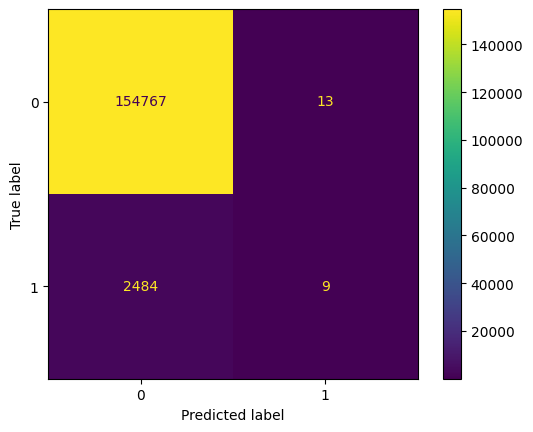

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

#### Confusion Matrix of undersampled Training set

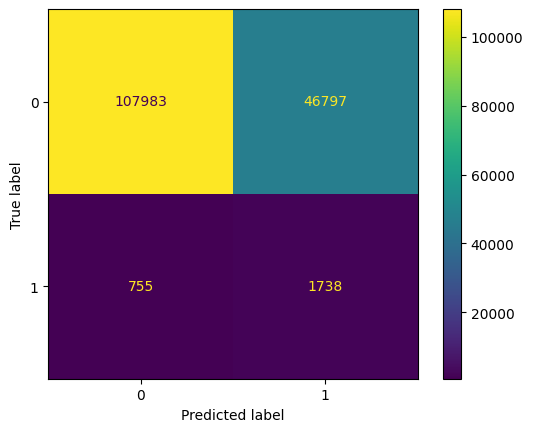

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_under)
plt.show()

#### Confusion Matrix of oversampled Training set

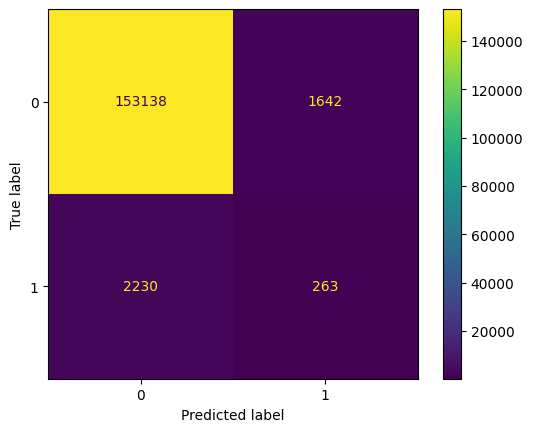

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_over)
plt.show()

In [28]:
# cf_matrix = confusion_matrix(y_test, y_pred)
# cf_matrix
# cf_matrix.ravel()

### Models Classification Reports

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    154780
           1       0.41      0.00      0.01      2493

    accuracy                           0.98    157273
   macro avg       0.70      0.50      0.50    157273
weighted avg       0.98      0.98      0.98    157273



In [30]:
print(classification_report(y_test, y_pred_under))

              precision    recall  f1-score   support

           0       0.99      0.70      0.82    154780
           1       0.04      0.70      0.07      2493

    accuracy                           0.70    157273
   macro avg       0.51      0.70      0.44    157273
weighted avg       0.98      0.70      0.81    157273



In [31]:
print(classification_report(y_test, y_pred_over))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    154780
           1       0.14      0.11      0.12      2493

    accuracy                           0.98    157273
   macro avg       0.56      0.55      0.55    157273
weighted avg       0.97      0.98      0.97    157273



### AUC Score and ROC Curve

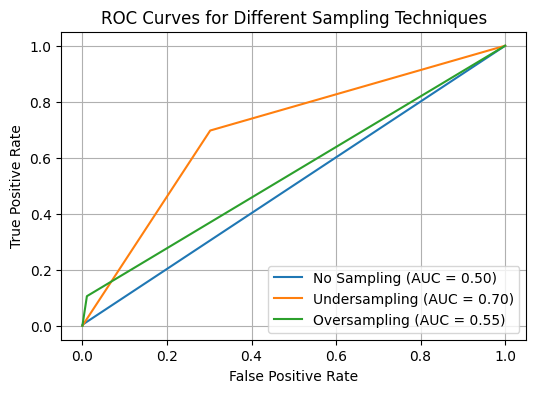

In [43]:
# Plot ROC curves
fig, ax = plt.subplots(figsize = (6, 4))

# Plot ROC curve for no sampling (original data)
RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax, name='No Sampling')

# Plot ROC curve for undersampling
RocCurveDisplay.from_predictions(y_test, y_pred_under, ax=ax, name='Undersampling')

# Plot ROC curve for oversampling
RocCurveDisplay.from_predictions(y_test, y_pred_over, ax=ax, name='Oversampling')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Sampling Techniques')
plt.legend()
plt.grid(True)
plt.show()

The Undersampled model has the highest AUC score (0.70). 
The higher the AUC score the better because the more accurate the model will be at predicting the correct class.

## Conclusion

### Classification: Precision and Recall: A Tug of War - [Google](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
- Precision: What proportion of positive identifications was actually correct?
- Recall: What proportion of actual positives was identified correctly?

So what can we learn from this? well it is evident that: 
- (1) Accuracy score alone is not enough to determine the effectiveness of a classification model
- (2) Over-sampling, Under-sampling and other sampling methods can be used to improve a classification model's performace
- (3) To fully evaluate the effectiveness of a model, you must examine both precision and recall. Unfortunately, precision and recall are often in    tension. That is, improving precision typically reduces recall and vice versa.
- (4) Precision and Recall are affected by the accuracy score of our model.
- (5) Even though under-sampling led to a reduction in model accuracy score, it improved the model's ability to detect fraudulent transactions when compared to the models without resampling and the oversampled model, but this also led to a lot more non-fraudulent transactions being classified as fraudulent.